In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# 학습용 데이터 만들기

In [20]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/blk'
folder_list = os.listdir(base_dir)

batch_size = 1
batch_x_data = list()
batch_t_data = list()

frame_num = 20

for folder in folder_list[0:1*batch_size]:
    for n in range(10):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(40+(i*((len(file_list)-80)/frame_num)))))+'.jpg'))
            img = img.resize(size=(112, 112))
            img = np.array(img)
            img = img.reshape(112,112,1)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

In [21]:
# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
print(batch_x_data.shape)

(10, 20, 112, 112, 1)


In [22]:
# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

print(batch_x_data.shape)

(10, 112, 112, 20, 1)


In [23]:
# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
display(batch_t_data)
batch_t_data = pd.get_dummies(batch_t_data['t'])
display(batch_t_data)

,t
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1


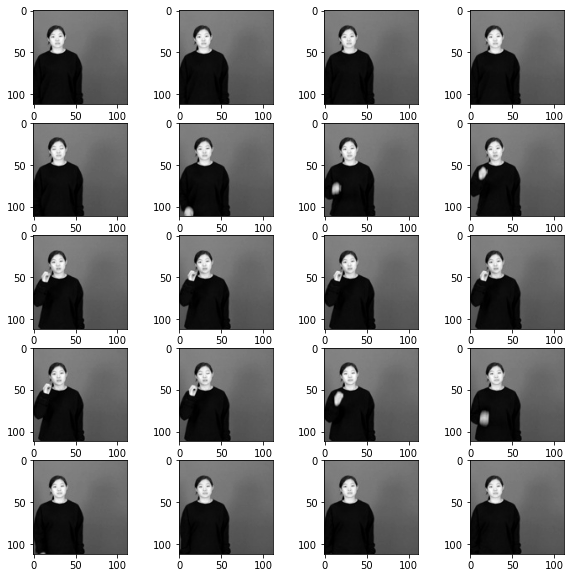

In [25]:
# 데이터 확인
figure = plt.figure(figsize=(10,10))

fig_list=list()
for i in range(20):
    fig_list.append(figure.add_subplot(5,4,i+1))
    test = batch_x_data[0,:,:,i,:]
    fig_list[i].imshow(test.reshape(112,112,1), cmap='gray')

# 모델

In [2]:
# GPU 메모리제한
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
    except RuntimeError as e:
        # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [3]:
# 모델 작성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv3D, MaxPool3D,Flatten, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2

weight_decay = 0.005
frame_num = 15
num_class = 10
input_shape=(56,56)

model = Sequential()
model.add(Conv3D(64,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=input_shape+(frame_num,1)))
model.add(MaxPool3D((2,2,1),strides=(2,2,1),padding='same'))

model.add(Conv3D(128,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Flatten())
model.add(Dense(units=int(4096), activation='relu'))
model.add(Dense(units=int(4096), activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_class, activation='softmax'))
model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 56, 56, 15, 64)    1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 28, 28, 15, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 28, 28, 15, 128)   221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 14, 8, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 14, 14, 8, 256)    884992    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 14, 14, 8, 256)    1769728   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 7, 4, 256)      0

In [4]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/blk'
folder_list = os.listdir(base_dir)

batch_size = 3
shuffle_list = list(range(0,num_class))*batch_size

for batch in range(int((80-batch_size)/batch_size)):
    batch_x_data = list()
    batch_t_data = list()
    for folder in folder_list[batch*batch_size:(batch+1)*batch_size]:
        for n in range(num_class):
            file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
            temp_data = list()
            for i in range(frame_num):
                img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(40+(i*((len(file_list)-80)/frame_num)))))+'.jpg'))
                img = img.resize(size=input_shape)
                img = np.array(img)
                # 흑백 이미지 전용 코드
                img = img.reshape(56, 56, 1)
                temp_data.append(img)
            temp_data = np.array(temp_data)
            batch_x_data.append(temp_data)
            batch_t_data.append(n)

    # 리스트인 batch_x_data를 ndarray로
    batch_x_data = np.array(batch_x_data)
    batch_t_data = np.array(batch_t_data)
    
    # 축변경
    batch_x_data = np.swapaxes(batch_x_data,1,2)
    batch_x_data = np.swapaxes(batch_x_data,2,3)
    
    # data shuffle
    random.shuffle(shuffle_list)
    
    batch_x_data = batch_x_data[shuffle_list]
    batch_t_data = batch_t_data[shuffle_list]

    # one_hot_encording
    batch_t_data = np.array(batch_t_data)
    batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
    batch_t_data = pd.get_dummies(batch_t_data['t'])
    
    # learning
    history = model.fit(x=batch_x_data, y=batch_t_data, epochs=20, verbose=1, validation_split=0.3)

Epoch 1/20
1/1 [==============================] - 0s 399ms/step - loss: 14.3760 - accuracy: 0.0476 - val_loss: 44.7835 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 284ms/step - loss: 35.3790 - accuracy: 0.1429 - val_loss: 14.0424 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 284ms/step - loss: 14.1334 - accuracy: 0.1429 - val_loss: 13.8997 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 283ms/step - loss: 13.8963 - accuracy: 0.1429 - val_loss: 13.8357 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 282ms/step - loss: 13.7805 - accuracy: 0.1429 - val_loss: 13.7878 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 287ms/step - loss: 13.6979 - accuracy: 0.1429 - val_loss: 13.7478 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 284ms/step - loss: 13.6145 - accuracy: 0.1429 - val_loss: 13.6927 - val

1/1 [==============================] - 0s 284ms/step - loss: 10.5870 - accuracy: 0.1905 - val_loss: 11.0941 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 286ms/step - loss: 10.8307 - accuracy: 0.1429 - val_loss: 10.7406 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 288ms/step - loss: 10.6455 - accuracy: 0.2381 - val_loss: 10.7694 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 283ms/step - loss: 10.5259 - accuracy: 0.1905 - val_loss: 10.8264 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 0s 305ms/step - loss: 10.6707 - accuracy: 0.0476 - val_loss: 10.5505 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 285ms/step - loss: 10.4985 - accuracy: 0.1905 - val_loss: 10.5267 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 287ms/step - loss: 10.4042 - accuracy: 0.2381 - val_loss: 10.5113 - val_accurac

Epoch 14/20
1/1 [==============================] - 0s 298ms/step - loss: 7.2915 - accuracy: 0.0952 - val_loss: 8.0055 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 293ms/step - loss: 7.1743 - accuracy: 0.2381 - val_loss: 8.2363 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 0s 291ms/step - loss: 7.3299 - accuracy: 0.1429 - val_loss: 7.2693 - val_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 0s 296ms/step - loss: 7.2377 - accuracy: 0.1905 - val_loss: 7.2266 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 0s 295ms/step - loss: 7.1666 - accuracy: 0.1429 - val_loss: 7.2155 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 0s 302ms/step - loss: 7.1049 - accuracy: 0.0952 - val_loss: 7.2443 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 0s 302ms/step - loss: 7.0218 - accuracy: 0.1429 - val_loss: 7.5050 - val_accura

1/1 [==============================] - 0s 304ms/step - loss: 4.9231 - accuracy: 0.1429 - val_loss: 5.2842 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 306ms/step - loss: 4.8849 - accuracy: 0.1429 - val_loss: 4.9820 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 303ms/step - loss: 4.9009 - accuracy: 0.2381 - val_loss: 5.0958 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 302ms/step - loss: 4.7636 - accuracy: 0.1905 - val_loss: 5.1082 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 0s 303ms/step - loss: 4.6282 - accuracy: 0.2381 - val_loss: 4.8384 - val_accuracy: 0.1111
Epoch 16/20
1/1 [==============================] - 0s 305ms/step - loss: 4.5900 - accuracy: 0.3333 - val_loss: 10.4860 - val_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 0s 306ms/step - loss: 7.7422 - accuracy: 0.0952 - val_loss: 4.8275 - val_accuracy: 0.0000e+00


1/1 [==============================] - 0s 304ms/step - loss: 4.0613 - accuracy: 0.0952 - val_loss: 4.3906 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 306ms/step - loss: 4.0125 - accuracy: 0.1905 - val_loss: 4.6591 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 301ms/step - loss: 4.0834 - accuracy: 0.2381 - val_loss: 4.1179 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 305ms/step - loss: 4.0425 - accuracy: 0.2857 - val_loss: 4.1152 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 0s 302ms/step - loss: 4.0213 - accuracy: 0.2857 - val_loss: 4.1087 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 0s 304ms/step - loss: 3.9550 - accuracy: 0.2857 - val_loss: 4.1806 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 0s 306ms/step - loss: 3.8602 - accuracy: 0.3333 - val_loss: 4.3298 - val_accuracy: 0.0000e+0

1/1 [==============================] - 0s 302ms/step - loss: 5.1102 - accuracy: 0.1429 - val_loss: 3.6349 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 304ms/step - loss: 3.5150 - accuracy: 0.1429 - val_loss: 3.6183 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 302ms/step - loss: 3.4402 - accuracy: 0.1429 - val_loss: 3.5753 - val_accuracy: 0.1111
Epoch 8/20
1/1 [==============================] - 0s 303ms/step - loss: 3.3214 - accuracy: 0.2381 - val_loss: 3.5202 - val_accuracy: 0.1111
Epoch 9/20
1/1 [==============================] - 0s 303ms/step - loss: 3.1468 - accuracy: 0.3810 - val_loss: 3.4566 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 302ms/step - loss: 2.9374 - accuracy: 0.2857 - val_loss: 3.4451 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 0s 307ms/step - loss: 2.7856 - accuracy: 0.2857 - val_loss: 3.5407 - val_accuracy: 0.0000e+00
Epoch 12/

1/1 [==============================] - 0s 303ms/step - loss: 3.3083 - accuracy: 0.0476 - val_loss: 3.3581 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 301ms/step - loss: 3.2183 - accuracy: 0.1905 - val_loss: 3.2517 - val_accuracy: 0.1111
Epoch 4/20
1/1 [==============================] - 0s 301ms/step - loss: 3.1436 - accuracy: 0.0476 - val_loss: 3.1690 - val_accuracy: 0.1111
Epoch 5/20
1/1 [==============================] - 0s 305ms/step - loss: 3.0028 - accuracy: 0.0952 - val_loss: 2.8449 - val_accuracy: 0.1111
Epoch 6/20
1/1 [==============================] - 0s 307ms/step - loss: 2.8809 - accuracy: 0.2381 - val_loss: 7.2850 - val_accuracy: 0.1111
Epoch 7/20
1/1 [==============================] - 0s 304ms/step - loss: 5.0056 - accuracy: 0.0952 - val_loss: 3.1682 - val_accuracy: 0.3333
Epoch 8/20
1/1 [==============================] - 0s 303ms/step - loss: 3.2390 - accuracy: 0.2857 - val_loss: 3.1062 - val_accuracy: 0.3333
Epoch 9/20
1/1 [===============

1/1 [==============================] - 0s 304ms/step - loss: 2.3725 - accuracy: 0.5238 - val_loss: 3.7482 - val_accuracy: 0.1111
Epoch 1/20
1/1 [==============================] - 0s 321ms/step - loss: 9.2959 - accuracy: 0.1429 - val_loss: 3.1071 - val_accuracy: 0.2222
Epoch 2/20
1/1 [==============================] - 0s 305ms/step - loss: 3.1660 - accuracy: 0.1905 - val_loss: 2.9833 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 302ms/step - loss: 3.0669 - accuracy: 0.2857 - val_loss: 2.8753 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 306ms/step - loss: 2.9720 - accuracy: 0.2381 - val_loss: 2.7769 - val_accuracy: 0.4444
Epoch 5/20
1/1 [==============================] - 0s 302ms/step - loss: 2.8656 - accuracy: 0.2381 - val_loss: 2.6706 - val_accuracy: 0.2222
Epoch 6/20
1/1 [==============================] - 0s 303ms/step - loss: 2.7015 - accuracy: 0.4762 - val_loss: 2.5562 - val_accuracy: 0.3333
Epoch 7/20
1/1 [===============

1/1 [==============================] - 0s 303ms/step - loss: 1.3228 - accuracy: 0.8571 - val_loss: 8.5994 - val_accuracy: 0.4444
Epoch 19/20
1/1 [==============================] - 0s 301ms/step - loss: 2.0490 - accuracy: 0.7619 - val_loss: 4.2442 - val_accuracy: 0.2222
Epoch 20/20
1/1 [==============================] - 0s 305ms/step - loss: 2.1474 - accuracy: 0.5714 - val_loss: 3.6035 - val_accuracy: 0.3333
Epoch 1/20
1/1 [==============================] - 0s 320ms/step - loss: 3.1320 - accuracy: 0.0952 - val_loss: 3.3305 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 303ms/step - loss: 3.0936 - accuracy: 0.0000e+00 - val_loss: 2.8543 - val_accuracy: 0.1111
Epoch 3/20
1/1 [==============================] - 0s 304ms/step - loss: 2.7257 - accuracy: 0.2381 - val_loss: 2.5692 - val_accuracy: 0.1111
Epoch 4/20
1/1 [==============================] - 0s 300ms/step - loss: 2.4730 - accuracy: 0.1905 - val_loss: 2.2999 - val_accuracy: 0.4444
Epoch 5/20
1/1 [=====

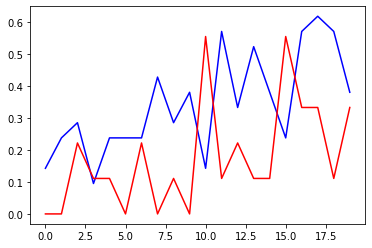

In [5]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.show()

In [6]:
batch_x_data = list()
batch_t_data = list()
for folder in folder_list[80-batch_size:80]:
    for n in range(num_class):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(40+(i*((len(file_list)-80)/frame_num)))))+'.jpg'))
            img = img.resize(size=input_shape)
            img = np.array(img)
            # 흑백 이미지 전용 코드
            img = img.reshape(56, 56, 1)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
batch_t_data = np.array(batch_t_data)

# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

# data shuffle
random.shuffle(shuffle_list)

batch_x_data = batch_x_data[shuffle_list]
batch_t_data = batch_t_data[shuffle_list]

# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
batch_t_data = pd.get_dummies(batch_t_data['t'])

In [7]:
result = model.evaluate(x=batch_x_data, y=batch_t_data)
print(result)

1/1 [==============================] - 0s 978us/step - loss: 4.2779 - accuracy: 0.1000
[4.277884006500244, 0.10000000149011612]
